<a href="https://colab.research.google.com/github/jabb4/AlexNet_Pokedex/blob/main/myPokedex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Pokemon Images classification using AlexNet-based CNN architecture

 
 

In [21]:
!pip install opendatasets
!pip install import_ipynb
import import_ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time 

from os import listdir
import os
import cv2 as cv
import glob
import opendatasets as od

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
from torch.optim import lr_scheduler 
from torchvision import transforms, utils
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torchvision.io import read_image
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from skimage import io, transform
import torch.optim as optim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
%cd /content/drive/MyDrive/Colab_Notebooks/project_exam/AlexNet_Pokedex/

/content/drive/MyDrive/Colab_Notebooks/project_exam/AlexNet_Pokedex


In [24]:
# model = AlexNet.AlexNet()
import  sys
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/project_exam/AlexNet_Pokedex/')
from tools.AlexNet import AlexNet
from tools.images_tools import *

In [31]:
od.download("https://www.kaggle.com/datasets/thedagger/pokemon-generation-one")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gianfrancoingratta
Your Kaggle Key: ··········


100%|██████████| 2.15G/2.15G [00:25<00:00, 90.6MB/s]

In [26]:
from torch.nn.common_types import Tensor
class PokemonImageDataset(Dataset):
  """ Pokemon images dataset """
  
  def __init__(self, list_of_pokemon_images, images_labels, transform = None):
    """
    Args:
        list_of_pokemon_images    list[string]: list of pokemon file path
        images_labels             list[string]: list of pokemon labels for each image
        transform                 (callable, optional): Optional transform to be applied on a semple
    """
    self.list_of_pokemon_images = list_of_pokemon_images
    self.images_labels          = images_labels
    self.transform              = transform

  def __len__(self):
    " returns the number of samples (images) in our dataset. "
    return len(self.list_of_pokemon_images)
  
  def __getitem__(self, idx : int) -> dict:
    """
    The __getitem__ function loads and returns a sample from the dataset at the given index idx. 
    Based on the index, it identifies the image’s location on disk, converts that to a tensor using read_image, 
    retrieves the corresponding label, 
    calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a dictionary.
    """
    if torch.is_tensor(idx): idx = idx.tolist()
    
    try: 
      image = read_image(self.list_of_pokemon_images[idx])
      label = self.images_labels[idx]
    except:
      image = read_image(self.list_of_pokemon_images[0])
      # print(f"image type {image.dtype}")
      label = self.images_labels[0]

    nof_channels = image.shape[0]

    if(nof_channels == 4): #deal with 4 channels -> cut 1 channel
      image = image[:3,:]
    elif(nof_channels == 1): #deal with 1  channels -> extend to 3 channels (2 redundant)
      image = image.expand(3,*image.shape[1:])


    sample = {"image":image, "label":label}
    
    if self.transform:
      sample = self.transform(sample)
    return sample




In [32]:
root_path = '/content/drive/MyDrive/Colab_Notebooks/project_exam/AlexNet_Pokedex/pokemon-generation-one/dataset/'

list_of_pokemons=['Mewtwo', 'Pikachu', 'Charmander', 'Bulbasaur', 'Squirtle']

numerical_label = dict(zip(list_of_pokemons,range(len(list_of_pokemons))))

list_of_images = [file for pokemon in list_of_pokemons for file in glob.glob(root_path + pokemon + "/*")]

list_of_labels = []

for image_path in list_of_images:
  for name, label in numerical_label.items():
    if name in image_path: list_of_labels.append(numerical_label[name])

In [33]:
print(f"example: image -> {list_of_images[0]}, label -> {list_of_labels[0]}")
print(f"example: image -> {list_of_images[1000]}, label -> {list_of_labels[1000]}")
print(f"number of images : {len(list_of_images)}, number of labels : {len(list_of_labels)}")

example: image -> /content/drive/MyDrive/Colab_Notebooks/project_exam/AlexNet_Pokedex/pokemon-generation-one/dataset/Mewtwo/00000000.jpg, label -> 0
example: image -> /content/drive/MyDrive/Colab_Notebooks/project_exam/AlexNet_Pokedex/pokemon-generation-one/dataset/Bulbasaur/00000104.png, label -> 3
number of images : 1470, number of labels : 1470


In [34]:
pokemon_dataset = PokemonImageDataset(list_of_images, list_of_labels)

sample :  0 torch.Size([3, 1000, 1000])
sample :  1 torch.Size([3, 1200, 1600])
sample :  2 torch.Size([3, 1200, 1600])
sample :  3 torch.Size([3, 1500, 1500])


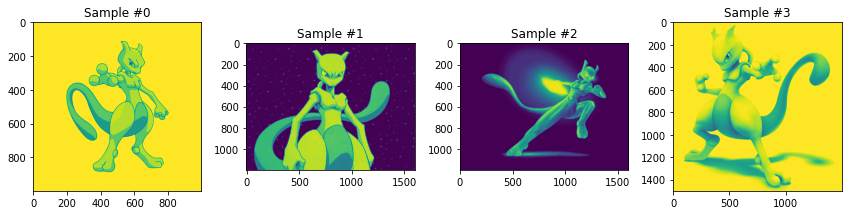

In [35]:
fig,ax = plt.subplots(1,4,figsize=(12,8))

for i, sample in enumerate(pokemon_dataset):
  print("sample : ", i, sample['image'].shape)
  plt.tight_layout()
  ax[i].set_title('Sample #{}'.format(i))
  # ax[i].axis('off')
  
  try:
    ax[i].imshow(sample["image"])
  except:
    ax[i].imshow(sample["image"][0])
    # print("4 images resized to 3 k")
  if i==3: break

In [36]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

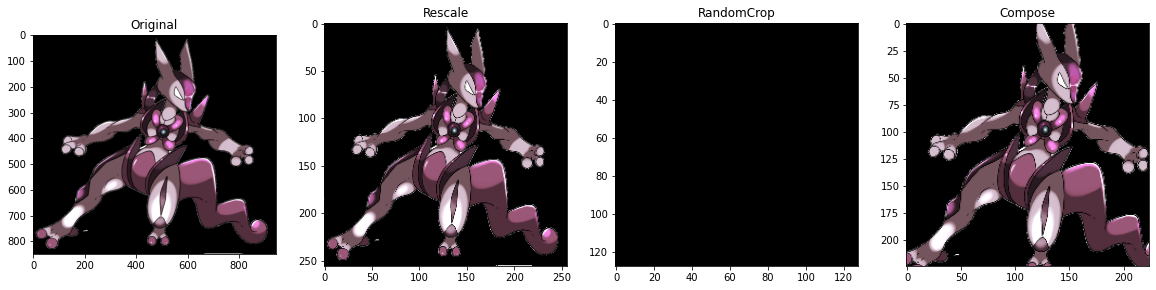

In [37]:
fig,ax = plt.subplots(1,4,figsize=(20,10))

sample = pokemon_dataset[38] # what if image has 4k resolution ?

ax[0].imshow(sample["image"].transpose(0,1).transpose(1,2))
ax[0].set_title("Original")

for i, tsfrm in enumerate([scale, crop, composed]):  
  transformed_sample = tsfrm(sample)
  # if(i==2):
  #     mean = (transformed_sample["image"].float()[0].mean(), transformed_sample["image"].float()[1].mean(), transformed_sample["image"].float()[2].mean())
  #     std  = (transformed_sample["image"].float()[0].std(),  transformed_sample["image"].float()[1].std(),  transformed_sample["image"].float()[2].std())
  #     norm = Normalize(mean, std)
  #     transformed_sample = norm(transformed_sample)

  ax[i+1].set_title(type(tsfrm).__name__)
  ax[i+1].imshow(transformed_sample["image"].transpose(0,1).transpose(1,2))

## **DATALOADERS**

In [38]:
pokemon_dataset = PokemonImageDataset(list_of_pokemon_images = list_of_images, 
                                      images_labels          = list_of_labels,
                                      transform              = transforms.Compose([Rescale(256),
                                                                                   RandomCrop(224)]
                                                                                  ))

pokemon_dataloader = DataLoader(pokemon_dataset, batch_size = 4, shuffle = True, num_workers=0)

batch number : 0, batch shape : torch.Size([4, 3, 224, 224]), batch[0] shapetorch.Size([3, 224, 224]), label tensor([4, 0, 3, 3])
batch number : 1, batch shape : torch.Size([4, 3, 224, 224]), batch[0] shapetorch.Size([3, 224, 224]), label tensor([4, 4, 4, 2])
batch number : 2, batch shape : torch.Size([4, 3, 224, 224]), batch[0] shapetorch.Size([3, 224, 224]), label tensor([0, 0, 3, 3])
batch number : 3, batch shape : torch.Size([4, 3, 224, 224]), batch[0] shapetorch.Size([3, 224, 224]), label tensor([1, 2, 0, 2])


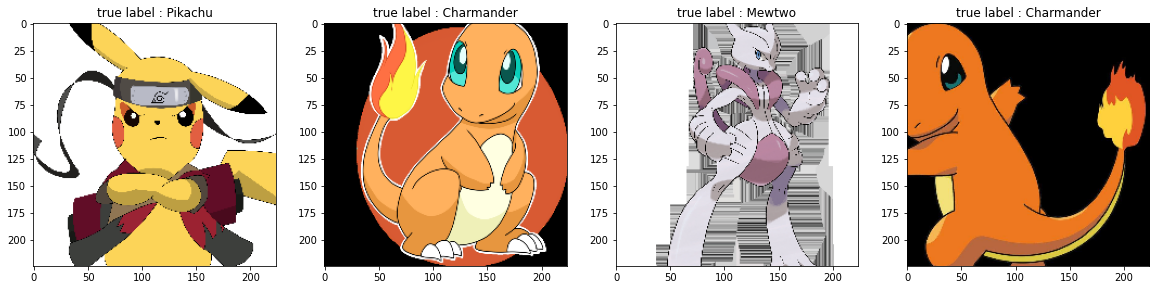

In [46]:
for i_batch, sample_batched in enumerate(pokemon_dataloader):
  image = sample_batched["image"]
  label = sample_batched["label"]
  print(f"batch number : {i_batch}, batch shape : {image.size()}, batch[0] shape{image[0].size()}, label {label}")
  
  if i_batch == 3:
    images_batch, label_batch = sample_batched['image'],sample_batched['label']
    batch_len = images_batch.shape[0]
    fig,ax = plt.subplots(1,batch_len, figsize = (20,10))
    for i in range(batch_len):
      ax[i].imshow(images_batch[i].permute(1,2,0))
      ax[i].set_title(f"true label : {list_of_pokemons[label_batch[i]]}")
    break

In [47]:
train, test_set = train_test_split(pokemon_dataset, test_size=0.2, train_size = 0.8, random_state = 42,shuffle=True)

In [48]:
train_set, validation_set =  train_test_split(train, test_size=0.25, train_size = 0.75, random_state = 42,shuffle=True)

In [49]:
print("training set size : {}, validation set size : {}, test set size : {}".format(len(train_set),len(validation_set),len(test_set)))

training set size : 882, validation set size : 294, test set size : 294


In [50]:
dataloaders = {'train': DataLoader(train_set, batch_size = 10, shuffle = True, num_workers=0), 
               'val'  : DataLoader(validation_set, batch_size = 10, shuffle = True, num_workers=0), 
               'test' : DataLoader(test_set, batch_size = 10, shuffle = True, num_workers=0)} 

dataset_sizes = {x: y for x,y in zip(['train', 'val','test'],[len(train_set),len(validation_set),len(test_set)])}

In [51]:
print(dataset_sizes["val"])

294


In [52]:
for dictionary in dataloaders['train']:
  print(dictionary['image'].shape)
  if i == 3: break

torch.Size([10, 3, 224, 224])


## TRAINING THE NETWORK


In [53]:
model = AlexNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## SPLIT : TRAINING VALIDATION & TEST SET

In [89]:
num_epochs = 10

since = time.time()
best_accuracy = 0.

train_accuracy, validation_accuracy, train_loss,  validation_loss = ([] for i in range(4))

for epoch in range(num_epochs):
  print(f'Epoch {epoch}/{num_epochs - 1}')
  print('-'*10)

  for phase in ['train','val']:
    if phase == 'train':
      model.train() # set model to training mode
    else:
      model.eval()   # set model to evaluate mode (tested on the validation set first)

    running_loss, running_corrects = 0.0, 0

    for running_data in dataloaders[phase]:
      images = running_data['image']
      labels = running_data['label']

      # zero the parameter gradients
      optimizer.zero_grad()
      # print("setting zero gradients")

      # forward
      # track history if only in train

      with torch.set_grad_enabled(phase == 'train'):
        # print("Alla fine l'input gli è piaciuto")
        outputs = model(images.float())
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

      # backward + optimize only if in training phase
        if phase == 'train':
          loss.backward()
          optimizer.step()

      running_loss += loss.item() * images.size(0)
      running_corrects += torch.sum(preds == labels.data)
    # (Da rivedere) call of the progress step per epoch
    if phase == 'train': 
      scheduler.step()
    
    #loss and accuracy evaluation per each epoch
    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_accuracy = running_corrects.double() / dataset_sizes[phase]

    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_accuracy:.4f}')
    if phase == 'train':
      train_accuracy.append(epoch_accuracy)
      train_loss.append(epoch_loss)
    if phase == 'val':
      validation_accuracy.append(epoch_accuracy)
      validation_loss.append(epoch_loss)
      
    if phase == 'val' and epoch_accuracy > best_accuracy:
      best_accuracy = epoch_accuracy
      # best_model_wts = copy.deepcopy(model.state_dict())
    
    print()

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val Acc: {best_accuracy:4f}')

# load best model weights
# model.load_state_dict(best_model_wts)





Epoch 0/9
----------
train Loss: 0.6959 Acc: 0.7698

val Loss: 1.0731 Acc: 0.7279

Epoch 1/9
----------
train Loss: 0.7142 Acc: 0.7823

val Loss: 0.5836 Acc: 0.7993

Epoch 2/9
----------
train Loss: 0.6227 Acc: 0.7925

val Loss: 0.6376 Acc: 0.7823

Epoch 3/9
----------
train Loss: 0.5518 Acc: 0.8322

val Loss: 0.4776 Acc: 0.8810

Epoch 4/9
----------
train Loss: 0.5633 Acc: 0.8186

val Loss: 0.5277 Acc: 0.8299

Epoch 5/9
----------
train Loss: 0.4114 Acc: 0.8560

val Loss: 0.4089 Acc: 0.9014

Epoch 6/9
----------
train Loss: 0.3342 Acc: 0.8866

val Loss: 0.3977 Acc: 0.8980

Epoch 7/9
----------
train Loss: 0.3608 Acc: 0.8855

val Loss: 0.3831 Acc: 0.8946

Epoch 8/9
----------
train Loss: 0.3281 Acc: 0.8900

val Loss: 0.3687 Acc: 0.9048

Epoch 9/9
----------
train Loss: 0.3299 Acc: 0.8889

val Loss: 0.3598 Acc: 0.9116

Training complete in 31m 35s
Best val Acc: 0.911565


294 294


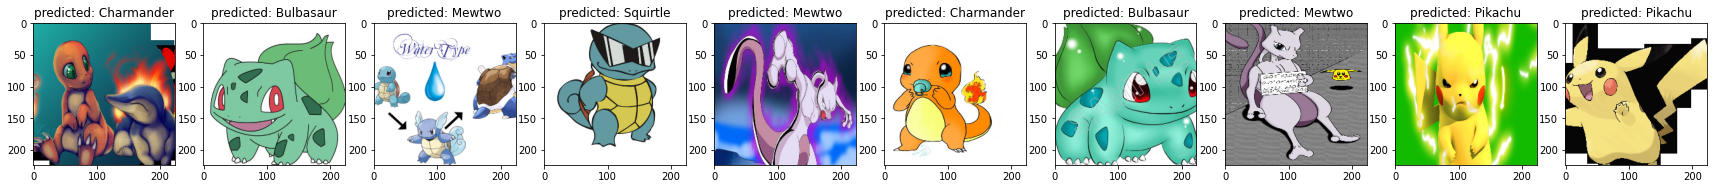

In [90]:
model.eval()
was_training = model.training

predicted_label, true_label = [],[]
print_images = 1
with torch.no_grad():
  for running_data in dataloaders['test']:
    images = running_data['image']
    labels = running_data['label']

    outputs = model(images.float())
    _, preds = torch.max(outputs, 1)

    predicted_label.append(preds)
    true_label.append(labels.data)

    if print_images == 1:
      fig,ax = plt.subplots(1,10, figsize=(30,15))
      for index,images in enumerate(images):
        ax[index].imshow(images.permute(1,2,0))
        ax[index].set_title(f"predicted: {list_of_pokemons[preds[index]]}")
    
    print_images = 0;


predicted_label = np.concatenate([i for i in predicted_label])
true_label = np.concatenate([i for i in true_label])
print(len(predicted_label),len(true_label))

# Plots

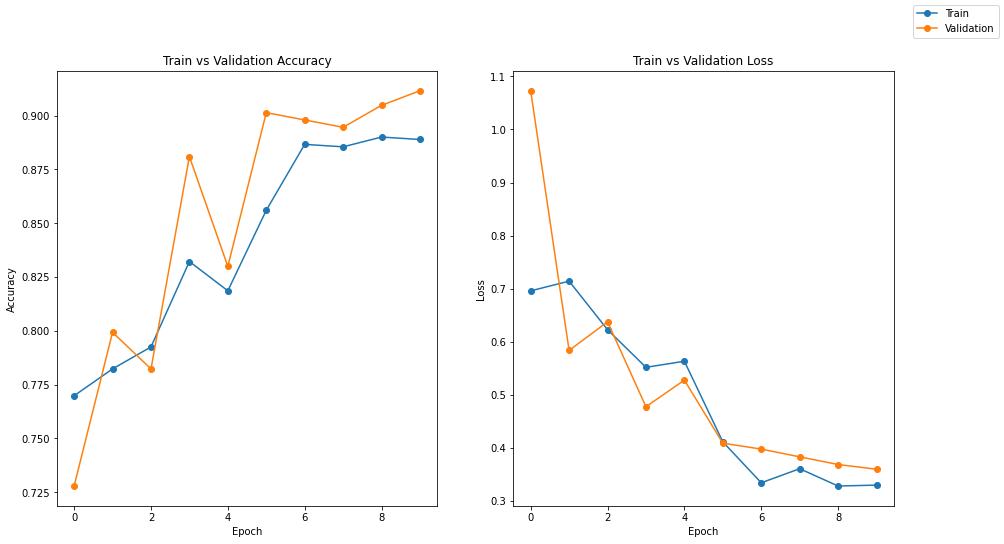

In [91]:
fig,ax = plt.subplots(1,2,figsize=(15,8))

ax[0].plot(train_accuracy,'-o')
ax[0].plot(validation_accuracy,'-o')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
# ax[0].set_legend(['Train','Validation'])
ax[0].set_title('Train vs Validation Accuracy')

ax[1].plot(train_loss,'-o')
ax[1].plot(validation_loss,'-o')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Train vs Validation Loss')

fig.legend(['Train','Validation'])


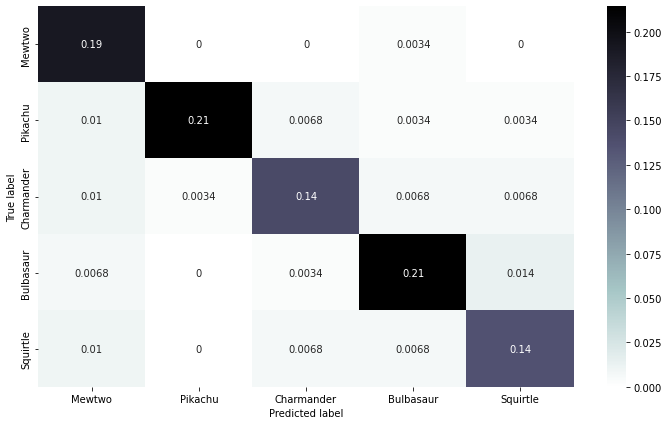

In [92]:
from sklearn.metrics import confusion_matrix

# Build confusion matrix
cf_matrix = confusion_matrix(true_label, predicted_label)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in list_of_pokemons],
                     columns = [i for i in list_of_pokemons])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True, cmap="bone_r")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

In [81]:
cf_matrix

array([[55,  0,  0,  2,  0],
       [ 3, 41, 10, 12,  4],
       [ 2,  2, 43,  2,  1],
       [ 1,  0,  1, 63,  5],
       [12,  0,  1,  1, 33]])

In [86]:
np.sum(cf_matrix/np.sum(cf_matrix))

1.0